# 305to320 (1-15 November)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Nov1-15woPe.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_305to320']
X = df.loc[:, ~df.columns.isin(['std_inz_AGS_305to320'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# First CatBoost Model with 155 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9994587781124817


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  3.070572699648914


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

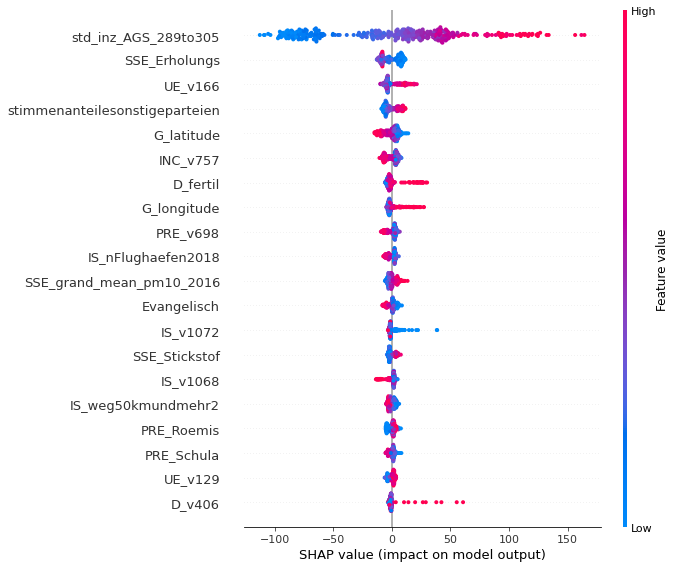

In [7]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9980059242358928


In [10]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  5.893896920144268


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_289to305', 'SSE_Erholungs', 'UE_v166', 'stimmenanteilesonstigeparteien', 'G_latitude', 'INC_v757', 'D_fertil', 'G_longitude', 'PRE_v698', 'IS_nFlughaefen2018'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_289to305', 'SSE_Erholungs', 'G_latitude', 'stimmenanteilesonstigeparteien', 'SSE_grand_mean_pm10_2016', 'PRE_v698', 'UE_v166', 'IS_weg50kmundmehr2', 'INC_v757', 'G_longitude']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_289to305
SSE_Erholungs
UE_v166
stimmenanteilesonstigeparteien
G_latitude
INC_v757
G_longitude
PRE_v698


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

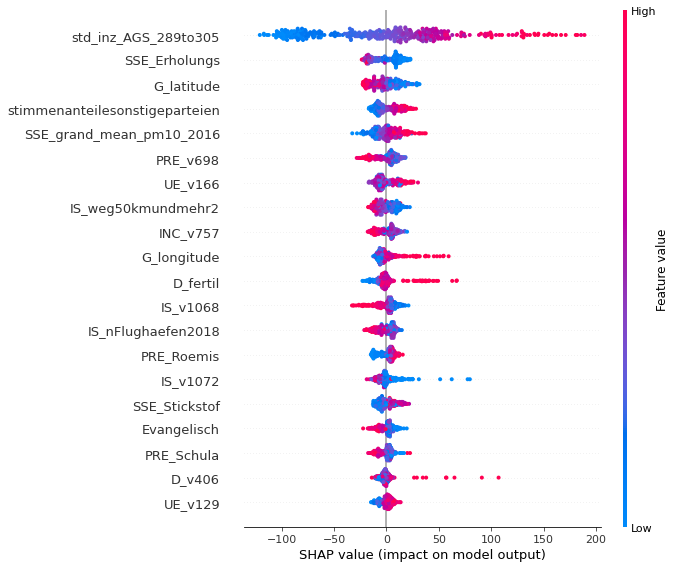

In [13]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9986245540340418
Mean R2 of linReg_modesl with top20 features:  0.7109964204290081
Mean RMSE of CatBoost_models on test sets with top20 features:  71.51002642608736
Mean R2 of CatBoost_models on test sets with top20 features: 0.7010440346424217


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_AGS_289to305,SSE_Erholungs,UE_v166,stimmenanteilesonstigeparteien,G_latitude,INC_v757,D_fertil,G_longitude,PRE_v698,IS_nFlughaefen2018,SSE_grand_mean_pm10_2016,Evangelisch,IS_v1072,SSE_Stickstof,IS_v1068,IS_weg50kmundmehr2,PRE_Roemis,PRE_Schula,UE_v129,D_v406
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,196.861191,70.509460,38.296265,5.217952,50.615307,8.945634,1.632220,9.866997,32.458591,49.618454,14.254108,30.085056,531.122192,68.331635,1050.970093,11.484292,32.242802,6.557357,5.669324,-3.954613
std,100.082146,56.734703,7.717491,1.823041,1.740311,2.964478,0.134031,2.026269,8.857036,21.984802,2.204698,16.709820,495.516693,27.160891,542.184448,3.481254,24.361443,2.242231,9.243234,4.800081
min,21.628151,14.000000,15.700000,2.000000,47.500000,-14.300000,1.060000,6.083333,0.000000,6.000000,8.902052,4.100000,103.000000,21.400000,13.000000,4.900000,1.700000,2.100000,-22.299999,-18.600000
25%,124.023865,39.700001,33.299999,3.800000,49.283333,7.700000,1.560000,8.216666,26.600000,33.000000,12.644478,16.100000,223.000000,47.500000,582.000000,9.000000,7.900000,4.900000,1.000000,-7.500000
50%,180.949234,52.799999,38.599998,4.700000,50.549999,9.000000,1.650000,9.766666,31.700001,48.000000,14.194455,26.299999,360.000000,59.200001,1056.000000,10.800000,29.100000,6.300000,8.500000,-4.200000
75%,250.004318,76.699997,43.299999,6.600000,51.849998,10.700000,1.720000,11.416667,38.200001,65.000000,15.811378,41.299999,617.000000,88.199997,1458.000000,13.300000,52.299999,8.000000,12.000000,-0.300000
max,613.031067,384.600006,68.300003,12.600000,54.783333,24.700001,1.940000,14.983334,57.900002,122.000000,21.132412,72.400002,4338.000000,150.699997,2782.000000,24.200001,87.800003,16.700001,26.600000,11.100000


In [17]:
pd.DataFrame(Y).describe()

,std_inz_AGS_305to320
count,401.000000
mean,294.754181
std,132.152008
min,51.452923
25%,187.580597
50%,295.148651
75%,375.239899
max,734.390442


In [ ]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')